In [1]:
#Load in data (adapted from ImportingDataIntoPandas)
import pandas as pd

#Note that for this to work the NoMoreSilence_ProjectData.tsv file needs to be
#in the same directory (folder) that this notebook file is in, and that you started
#the jupyter notebook from.

df = pd.read_csv('NoMoreSilence_ProjectData.tsv', sep='\t')

#this is creating a variable of all the sources, which we'll use to experiment with pulling out
#just the call number for each collection. 

#the for loop will iterate through each source, and use the .split method to create a new list
#with each element (separated by commas, which we specified with .split(', ') -- note 
# comma then space) as a list item.

#this threw an error, because one of the entries was a float not a string. We have to choose to 
#either make it a string or to ignore it. In this code I've made it a string with source = str(source)
#but it may actually be better to ignore it. (with an if else statement)

sources = df['Source']
for source in sources:
    source = str(source)
    s_list = source.split(', ')
    
#Filling out the above to more completely get the call number. Note that this time we are opting to skip
#the row if it has no data for the source, this is contained in the "if type(source) == str:"

collection_list = []
for source in sources:
    if type(source) == str:
        source_list = source.split(', ')
        try:
            if source_list[1] == '':
                collection_list.append(source_list[2])
            else:
                collection_list.append(source_list[1])
        except IndexError:
            collection_list.append('no data')

#the below makes a set from the list, to pull out all the unique values so we can see what the extent of the values
#we're getting. 
#we can see that there are some duplicates due to trailing spaces, so we'll need to fix that. 
            
collection_set = set(collection_list)

#We're almost there, but we want the code to remove trailing spaces and to replace spaces with dashes for cleaner data.
#The below does that.

collection_list = []
for source in sources:
    call_no = 'blank'
    if type(source) == str:
        source_list = source.split(', ')
        try:
            if source_list[1] == '':
                if source_list[2][-1] == ' ':
                    call_no = source_list[2][0:-1].replace(' ', '-')
                else:
                    call_no = source_list[2].replace(' ', '-')
            else:
                if source_list[1][-1] == ' ':
                    call_no = source_list[1][0:-1].replace(' ', '-')
                else:
                    call_no = source_list[1].replace(' ', '-')
        except IndexError:
            call_no = 'no-data'
    collection_list.append(call_no)
    
collection_set = set(collection_list)

#Now we need to take the code above and turn it into a function that will run on the "Source" field
#for every line in the dataframe. We need to define its inputs a little differently, and do the function
#definition.

def get_call_no(row):
    call_no = 'blank'
    if type(row['Source']) == str:
        source_list = row['Source'].split(', ')
        try:
            if source_list[1] == '':
                if source_list[2][-1] == ' ':
                    call_no = source_list[2][0:-1].replace(' ', '-')
                else:
                    call_no = source_list[2].replace(' ', '-')
            else:
                if source_list[1][-1] == ' ':
                    call_no = source_list[1][0:-1].replace(' ', '-')
                else:
                    call_no = source_list[1].replace(' ', '-')
        except IndexError:
            call_no = 'no-data'
    return call_no

#This used the function we just defined above to go through each row in the dataframe and pull out the call_no
#and put it into a new column called 'call_no', which we've defined simply by naming it in the 'df['call_no'] = ...'

df['call_no'] = df.apply(lambda row: get_call_no(row), axis=1)

#using the df.unique method, we can check the same thing we did above using set() -- that there are no repeat values. 

call_nums = df['call_no'].unique()

#and now we can sort it by collection simply by creating a variable that defines all the rows that match a certain 
#collection value, and passing this as a selection of the df variable:

act_up = df['call_no'] == 'MSS-98-47'
df[act_up]

,Collection Title,Title,Local Identifier,Type,Date,Date Type,Publication/Origination Info,Creator 1 Name,Creator 1 NameType,Creator 1 Source,...,Subject (Topic) 4 Heading Type,Subject (Topic) 4 Source,Subject (Topic) 5 Heading,Subject (Topic) 5 Heading Type,Subject (Topic) 5 Source,Subject (Topic) 6 Heading,Subject (Topic) 6 Heading Type,Subject (Topic) 6 Source,Ocr text,call_no
639,"ACT-UP Golden Gate Records, MSS 98-47, Box 1 F...",6th International AIDS Conference - Various Or...,ucsf_mss98-47_001_0016,text,1988-1993,created,Digital resource published by the Regents of t...,ACT UP Golden Gate (Organization),corpname,naf,...,,,,,,,,,The Quilt AnInternational AIDSMemorial CONTACT...,MSS-98-47
640,"ACT-UP Golden Gate Records, MSS 98-47, Box 1 F...",Newspaper Clippings,ucsf_mss98-47_001_0018,text,"1989-1990, undated",created,Digital resource published by the Regents of t...,ACT UP Golden Gate (Organization),corpname,naf,...,,,,,,,,,Hdirin^cfnAid Cuts Disrupted in Phil^elphia (^...,MSS-98-47
641,"ACT-UP Golden Gate Records, MSS 98-47, Box 1 F...",ACT-UP Golden Gate - Treatment Issues Committee,ucsf_mss98-47_001_003,text,1991-1992,created,Digital resource published by the Regents of t...,ACT UP Golden Gate (Organization),corpname,naf,...,,,,,,,,,"To: AIDS Activists, Service Organizations, Com...",MSS-98-47
642,"ACT-UP Golden Gate Records, MSS 98-47, Box 1 F...",ATAC² - 2nd AIDS Treatment Activist Conference,ucsf_mss98-47_001_008,text,1990,created,Digital resource published by the Regents of t...,ACT UP Golden Gate (Organization),corpname,naf,...,,,,,,,,,CONFERENCESUMMARY A SummaryoftheSecondAIDSTrea...,MSS-98-47
643,"ACT-UP Golden Gate Records, MSS 98-47, Box 1 F...",6th International AIDS Conference - 1990 ACT-U...,ucsf_mss98-47_001_005,text,1989,created,Digital resource published by the Regents of t...,ACT UP Golden Gate (Organization),corpname,naf,...,,,,,,,,,EMBARGO FOR RELEASE: AIDSCoalition ToUnleash P...,MSS-98-47
644,"ACT-UP Golden Gate Records, MSS 98-47, Box 1 F...","ACT-UP Washington, D.C.",ucsf_mss98-47_001_0014,text,1988-1989,created,Digital resource published by the Regents of t...,ACT UP Golden Gate (Organization),corpname,naf,...,,,,,,,,,i-» NGUF lesbian GAY AIDSCoalitionToUnleashPow...,MSS-98-47
645,"ACT-UP Golden Gate Records, MSS 98-47, Box 1 F...",AIDS Action News (Toronto),ucsf_mss98-47_001_0015,text,"1988-1992, undated",created,Digital resource published by the Regents of t...,ACT UP Golden Gate (Organization),corpname,naf,...,,,,,,,,,"Inside: If you'vefiadPCP, youmayneed HelpWante...",MSS-98-47
646,"ACT-UP Golden Gate Records, MSS 98-47, Box 1 F...",ATAC - AIDS Treatment Activist Conference,ucsf_mss98-47_001_0010,text,November 1990,created,Digital resource published by the Regents of t...,ACT UP Golden Gate (Organization),corpname,naf,...,,,,,,,,,"Sunday, 11 November 1990 - Quality Hotel Capit...",MSS-98-47
647,"ACT-UP Golden Gate Records, MSS 98-47, Box 1 F...",6th International AIDS Conference - San Franci...,ucsf_mss98-47_001_006,text,1990,created,Digital resource published by the Regents of t...,ACT UP Golden Gate (Organization),corpname,naf,...,,,,,,,,,Background Th* AIDS Coalition to Unlaash Power...,MSS-98-47
649,"ACT-UP Golden Gate Records, MSS 98-47, Box 1 F...",Treatment Issues ACT-UP Golden Gate and other ...,ucsf_mss98-47_001_0011,text,September 1991,created,Digital resource published by the Regents of t...,ACT UP Golden Gate (Organization),corpname,naf,...,,,,,,,,,CMngSTMJkS cancelled: SantaissickwithHIV-infec...,MSS-98-47


In [2]:
#Rename columns to get rid of some spaces.
df.columns = [x.strip(' ') for x in list(df.columns)]

#Grab one document identifier.
document_id = df[act_up].iloc[0]['Local Identifier']

#Grab that document.
document = df.loc[df['Local Identifier'] == document_id]
print(document)

                                      Collection Title  \
639  ACT-UP Golden Gate Records, MSS 98-47, Box 1 F...   

                                                 Title  \
639  6th International AIDS Conference - Various Or...   

           Local Identifier  Type       Date Date Type  \
639  ucsf_mss98-47_001_0016  text  1988-1993   created   

                          Publication/Origination Info  \
639  Digital resource published by the Regents of t...   

                        Creator 1 Name Creator 1 NameType Creator 1 Source  \
639  ACT UP Golden Gate (Organization)           corpname              naf   

       ...     Subject (Topic) 4 Heading Type Subject (Topic) 4 Source  \
639    ...                                                               

    Subject (Topic) 5 Heading Subject (Topic) 5 Heading Type  \
639                                                            

    Subject (Topic) 5 Source Subject (Topic) 6 Heading  \
639                                    

In [3]:
#Let's take a look at the column "Ocr text" (OCR stands for optical character recognition)
#For more info see here: https://towardsdatascience.com/a-gentle-introduction-to-ocr-ee1469a201aa
#Anyone notice any issues?
str(document["Ocr text"].values[0])

'The Quilt AnInternational AIDSMemorial CONTACT:DanSauro SueBaelen FORIMMEDIATERELEASE 415/863-5511-Phone 415/863-0708-Fax NAMES PROJECTJOINSBOYCOTTOF VlthINTERNATIONALCONFERENCEONAIDS Action SupportsPermanentLiftingofU.S.TravelRestrictionsforHIVInfectedPersons SectionsoftheAIDSMemorial QuiltStilltobeDisplayedinSanFrancisco in ConjimctionWithLesbianandGayPrideWeekend San Francisco,CA,March15,1990—TheBoardofDirectorsoftheNAMES ProjectFoundation,theSan Frandsco-based sponsoroftheInternationalAIDSMemorialQuilt,havededdedtoboycotttheVlth InternationalConferenceon AIDS,whichwillbeheldinSanFrandsco,June20-24. The boycottisin responsetotheU5.federalgovernment\'svisarestrictionsdiscriminatingagainstpeoplewithHIV infection.The temporaryliftingoftheserestrictionsisiiuufficientanddoesnotalterboycottplans. "Itiswithmixedemotionsthatweannounceourdedsionto boycott,"saidDavidLemos,Acting ExecutiveDirectoroftheNAMES Project. "Whilewerealizethetremendousneedforthisannual forumforAIDS information,weabho

In [4]:
#We need to add spaces between words! But how do we know what is and isn't a word?
document_text = document["Ocr text"].values[0]

#First, what language is this text?
from langdetect import detect
detect(document_text)

'en'

In [5]:
#One way would be to get a list of "all" words from GitHub.
#https://github.com/dwyl/english-words
import requests

def load_words():
    target_url = 'https://raw.githubusercontent.com/dwyl/english-words/master/words_alpha.txt'
    response = requests.get(target_url)
    data = response.text
    valid_words = set(data.split())
    
    return valid_words

#english_words = load_words()
#print(english_words)

In [6]:
#Oh no! It didn't work!
#What else could we do?
#Maybe NLP?
import nltk

#This will open a Window to download files for the NLTK package.
#nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [9]:
#Let's split sentences and then do words, one chunk at a time.
from nltk.tokenize import sent_tokenize, word_tokenize

#Get a sentence!
sentences = sent_tokenize(document_text)

#Some look good and others... Not so much.
print(sentences)

['The Quilt AnInternational AIDSMemorial CONTACT:DanSauro SueBaelen FORIMMEDIATERELEASE 415/863-5511-Phone 415/863-0708-Fax NAMES PROJECTJOINSBOYCOTTOF VlthINTERNATIONALCONFERENCEONAIDS Action SupportsPermanentLiftingofU.S.TravelRestrictionsforHIVInfectedPersons SectionsoftheAIDSMemorial QuiltStilltobeDisplayedinSanFrancisco in ConjimctionWithLesbianandGayPrideWeekend San Francisco,CA,March15,1990—TheBoardofDirectorsoftheNAMES ProjectFoundation,theSan Frandsco-based sponsoroftheInternationalAIDSMemorialQuilt,havededdedtoboycotttheVlth InternationalConferenceon AIDS,whichwillbeheldinSanFrandsco,June20-24.', "The boycottisin responsetotheU5.federalgovernment'svisarestrictionsdiscriminatingagainstpeoplewithHIV infection.The temporaryliftingoftheserestrictionsisiiuufficientanddoesnotalterboycottplans.", '"Itiswithmixedemotionsthatweannounceourdedsionto boycott,"saidDavidLemos,Acting ExecutiveDirectoroftheNAMES Project.', '"Whilewerealizethetremendousneedforthisannual forumforAIDS informati

In [10]:
#Let's get one sentence.
example_sentence = sentences[5]
print(example_sentence)

ThetravelrestrictionsareindiredconflictwiththeNAMES Project'sobjectiveofworking towardanimmediateand compassionate responsetotheAIDSpandemic.


In [11]:
#Let's try to split apart the words.
words = word_tokenize(example_sentence)
print(words)

['ThetravelrestrictionsareindiredconflictwiththeNAMES', "Project'sobjectiveofworking", 'towardanimmediateand', 'compassionate', 'responsetotheAIDSpandemic', '.']


In [12]:
#Let's try a spell checker again, but make it more efficient.
#https://stackoverflow.com/questions/8870261/how-to-split-text-without-spaces-into-list-of-words
import wordninja

spell_checked_words = wordninja.split(example_sentence)
print(spell_checked_words)

['The', 'travel', 'restrictions', 'are', 'in', 'di', 'red', 'conflict', 'with', 'the', 'NAMES', "Project's", 'objective', 'of', 'working', 'toward', 'an', 'immediate', 'and', 'compassionate', 'response', 'to', 'the', 'AIDS', 'pandemic']


In [13]:
#Not perfect, but definitely better!
#Let's put the sentence back together:

corrected_sentence = " ".join(spell_checked_words)
print(corrected_sentence)

#There are better ways to do this that employ deep learning models
#but they are a bit too complicated to go into detail here.
#For example: https://github.com/atpaino/deep-text-corrector

The travel restrictions are in di red conflict with the NAMES Project's objective of working toward an immediate and compassionate response to the AIDS pandemic


In [14]:
#Can we find out anything else from a sentence?

#Let's look at grammar first (parts of speech, specifically).
nltk.pos_tag(word_tokenize(corrected_sentence))

[('The', 'DT'),
 ('travel', 'NN'),
 ('restrictions', 'NNS'),
 ('are', 'VBP'),
 ('in', 'IN'),
 ('di', 'JJ'),
 ('red', 'JJ'),
 ('conflict', 'NN'),
 ('with', 'IN'),
 ('the', 'DT'),
 ('NAMES', 'NNP'),
 ('Project', 'NNP'),
 ("'s", 'POS'),
 ('objective', 'NN'),
 ('of', 'IN'),
 ('working', 'VBG'),
 ('toward', 'IN'),
 ('an', 'DT'),
 ('immediate', 'JJ'),
 ('and', 'CC'),
 ('compassionate', 'JJ'),
 ('response', 'NN'),
 ('to', 'TO'),
 ('the', 'DT'),
 ('AIDS', 'NNP'),
 ('pandemic', 'NN')]

In [15]:
#What do these abbreviations mean?
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

In [16]:
#We can also look at the sentence's sentiment.
#That is, positivity, negativity, or neutrality.
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

sia = SIA()
pol_score = sia.polarity_scores(corrected_sentence)
print(pol_score)

#Seems like it is mostly neutral!

{'neg': 0.081, 'neu': 0.807, 'pos': 0.112, 'compound': 0.2263}


In [17]:
#Let's go through and correct each sentence of our OCR.
corrected_ocr = []

for sentence in sentences:
    spell_checked_words = wordninja.split(sentence)
    corrected_sentence = " ".join(spell_checked_words)
    corrected_ocr.append(corrected_sentence)
    
print(corrected_ocr)

['The Quilt An International AIDS Memorial CONTACT Dan Sauro Sue Baelen FOR IMMEDIATE RELEASE 415 863 5511 Phone 415 863 0708 Fax NAMES PROJECT JOINS BOYCOTT OF Vl th INTERNATIONAL CONFERENCE ON AIDS Action Supports Permanent Lifting of U S Travel Restrictions for HIV Infected Persons Sections of the AIDS Memorial Quilt Still to be Displayed in San Francisco in Con jim c tion With Lesbian and Gay Pride Weekend San Francisco CA March 15 1990 The Board of Directors of the NAMES Project Foundation the San Fr and sco based sponsor of the International AIDS Memorial Quilt have ded ded to boycott the Vl th International Conference on AIDS which will beheld in San Fr and sco June 20 24', "The boycott is in response to the U 5 federal government's visa restrictions discriminating against people with HIV infection The temporary lifting of these restrictions is ii u u ff ici ent and does not alter boycott plans", 'It is with mixed emotions that we announce our de dsi on to boycott said David Le 

In [96]:
#Wow that's pretty long... Can we summarize it?
#Well yes! But it's complicated.
#Great step-by-step tutorial here:
#https://stackabuse.com/text-summarization-with-nltk-in-python/
#But we'll use a pre-existing package, sumy.

from sumy.parsers.html import HtmlParser
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer as Summarizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words

LANGUAGE = "english"
SENTENCES_COUNT = 1

full_text = ". ".join(corrected_ocr)
parser = PlaintextParser.from_string(full_text, Tokenizer(LANGUAGE))
stemmer = Stemmer(LANGUAGE)
summarizer = Summarizer(stemmer)
summarizer.stop_words = get_stop_words(LANGUAGE)

for sentence in summarizer(parser.document, SENTENCES_COUNT):
    print(sentence)

Thus our He aldi is a sham a shocking sinful ERN MENT RESEARCH IS INVEST IGA lives are totally in its hands and its sewer of ineptitude run by idiots n in 36 OUT T WEEK March 14 1990 pg N br 8 TOR IN mATED NOT GOAL ORIENT ED In ether words any stupid as sh de can submit a grant proposal for funding even if every lab in the wo rid is already qM S of Bq studying the same stupid di ing God for bid Dr s. Tc xi y Fau dor S amBr oder or Paul Vol bet xi in gorM aig art t F is c bl or Thomas Mer riga norD an Hoth or Larry Your convenient source for Corey or Martin H irs di some of these gay Interest fia lon and non fl ctf on people are not your friends i ro matter how nice you think they are should books and paperbacks then go out and LOCATE an investigator arr d hire him her to research the question Magazines of all Interests Classics like you hire an actor to play apart Ibis Travel Science Fiction st t id attitude could very well bet be dead Video Sales and Rentals of us.


In [99]:
#Are there other summary methods?
from sumy.summarizers.edmundson import EdmundsonSummarizer as Edmundson
from sumy.summarizers.luhn import LuhnSummarizer as Luhn

print("\nLuhn:")
summarizer = Luhn(stemmer)
summarizer.stop_words = get_stop_words(LANGUAGE)

for sentence in summarizer(parser.document, SENTENCES_COUNT):
    print(sentence)

Edumundson:

Luhn:
pr boycott pg N br 12 NATIONAL GAY LESBIAN TASK FORCE 1517 U STREET NW WASHINGTON DC 20009 202 332 6483 for more information for immediate release Robert Bray or Ur va shi V aid 202 332 6483 NG LT F executive director protests bush policies at presidential aids address Washington D C March 29 1990 President George Bush's first major address on the AIDS health crisis was interrupted today by Ur va shi V aid executive director of the National Gay and Lesbian Task Force NG LT F who stood up during the presentation and urged the President to do more for people with AIDS.


In [18]:
#Slightly better! Turns out text quality is pretty important here.

#Now let's do sentiment analysis on each sentence.
sia = SIA()
polarity_results = []
for sentence in corrected_ocr:
    pol_score = sia.polarity_scores(sentence)
    pol_score["sentence"] = sentence
    polarity_results.append(pol_score)
    
#Load into dataframe.
sentences_df = pd.DataFrame.from_records(polarity_results)
sentences_df.head()

,compound,neg,neu,pos,sentence
0,-0.5622,0.067,0.894,0.039,The Quilt An International AIDS Memorial CONTA...
1,-0.2023,0.120,0.807,0.073,The boycott is in response to the U 5 federal ...
2,-0.3182,0.087,0.913,0.000,It is with mixed emotions that we announce our...
3,-0.4588,0.167,0.833,0.000,While we realize the tremendous need for this ...
4,0.0000,0.000,1.000,0.000,government's travel poli des affecting people ...


In [19]:
#We can even do this with the entire document.
#But... It might take a while.

#Let's try something simpler with our corrected text.
#Let's stem all the words in the doc.
from nltk.stem import PorterStemmer

ps = PorterStemmer()
stemmed_words = []

for sentence in corrected_ocr:
    for words in word_tokenize(sentence):
            stemmed_words.append(ps.stem(words))
                
print(stemmed_words[:20])

['The', 'Quilt', 'An', 'Intern', 'AID', 'Memori', 'CONTACT', 'Dan', 'Sauro', 'Sue', 'Baelen', 'FOR', 'IMMEDI', 'RELEAS', '415', '863', '5511', 'Phone', '415', '863']


In [20]:
#So we have a lot that doesn't tell us anything... yet.

#Let's start by removing the numbers.
without_numbers = []

for word in stemmed_words:
    new_string = "".join([x for x in word if not x.isdigit()])
    if new_string:
        without_numbers.append(new_string)
        
print(without_numbers[:20])

['The', 'Quilt', 'An', 'Intern', 'AID', 'Memori', 'CONTACT', 'Dan', 'Sauro', 'Sue', 'Baelen', 'FOR', 'IMMEDI', 'RELEAS', 'Phone', 'Fax', 'NAME', 'PROJECT', 'JOIN', 'BOYCOTT']


In [21]:
#Next, let's make everything lowercase.
lowercase_words = [x.lower() for x in without_numbers]
print(lowercase_words[:20])

['the', 'quilt', 'an', 'intern', 'aid', 'memori', 'contact', 'dan', 'sauro', 'sue', 'baelen', 'for', 'immedi', 'releas', 'phone', 'fax', 'name', 'project', 'join', 'boycott']


In [22]:
#Now let's look at word frequency.
unique_words = set(lowercase_words)
word_freq = {}

for word in unique_words:
    word_freq[word] = lowercase_words.count(word)
    
#Sorted by frequency.
sorted_word_freq = sorted(word_freq.items(), key=lambda kv: kv[1], reverse=True)
print(sorted_word_freq[:50])

[('the', 885), ('and', 514), ('of', 513), ('to', 471), ('aid', 353), ('in', 294), ('a', 268), ('for', 199), ('is', 174), ('we', 161), ('confer', 161), ('on', 161), ('with', 157), ('be', 133), ('are', 132), ('that', 126), ('s', 124), ('act', 114), ('peopl', 109), ('as', 107), ('thi', 102), ('it', 99), ('intern', 98), ('hiv', 95), ('at', 88), ('will', 88), ('have', 87), ('up', 87), ('not', 86), ('san', 83), ('gay', 78), ('i', 75), ('from', 72), ('n', 71), ('you', 71), ('health', 71), ("'s", 71), ('francisco', 70), ('all', 69), ('or', 68), ('by', 64), ('june', 63), ('nation', 59), ('our', 56), ('who', 55), ('u', 54), ("'", 53), ('br', 51), ('pg', 51), ('organ', 49)]


In [23]:
#Notice anything?
#We need to remove a few things still...

#Like punctuation:
import string
without_punctuation = []

for word in lowercase_words:
    new_string = "".join([x for x in word if x not in string.punctuation])
    if new_string:
        without_punctuation.append(new_string)
        
unique_words = set(without_punctuation)
word_freq = {}
for word in unique_words:
    word_freq[word] = without_punctuation.count(word)
sorted_word_freq = sorted(word_freq.items(), key=lambda kv: kv[1], reverse=True)
print(sorted_word_freq[:50])

[('the', 885), ('and', 514), ('of', 513), ('to', 471), ('aid', 353), ('in', 294), ('a', 268), ('for', 199), ('s', 195), ('is', 174), ('we', 161), ('confer', 161), ('on', 161), ('with', 157), ('be', 133), ('are', 132), ('that', 126), ('act', 114), ('peopl', 109), ('as', 107), ('thi', 102), ('it', 99), ('intern', 98), ('hiv', 95), ('at', 88), ('will', 88), ('have', 87), ('up', 87), ('not', 86), ('san', 83), ('gay', 78), ('i', 75), ('from', 72), ('n', 71), ('you', 71), ('health', 71), ('francisco', 70), ('all', 69), ('or', 68), ('by', 64), ('june', 63), ('nation', 59), ('our', 56), ('who', 55), ('u', 54), ('br', 51), ('pg', 51), ('organ', 49), ('treatment', 49), ('ha', 47)]


In [24]:
#And single letters:
no_single_letters = []

for word in without_punctuation:
    if len(word) > 1:
        no_single_letters.append(word)
        
unique_words = set(no_single_letters)
word_freq = {}
for word in unique_words:
    word_freq[word] = no_single_letters.count(word)
sorted_word_freq = sorted(word_freq.items(), key=lambda kv: kv[1], reverse=True)
print(sorted_word_freq[:50])

[('the', 885), ('and', 514), ('of', 513), ('to', 471), ('aid', 353), ('in', 294), ('for', 199), ('is', 174), ('we', 161), ('confer', 161), ('on', 161), ('with', 157), ('be', 133), ('are', 132), ('that', 126), ('act', 114), ('peopl', 109), ('as', 107), ('thi', 102), ('it', 99), ('intern', 98), ('hiv', 95), ('at', 88), ('will', 88), ('have', 87), ('up', 87), ('not', 86), ('san', 83), ('gay', 78), ('from', 72), ('you', 71), ('health', 71), ('francisco', 70), ('all', 69), ('or', 68), ('by', 64), ('june', 63), ('nation', 59), ('our', 56), ('who', 55), ('br', 51), ('pg', 51), ('organ', 49), ('treatment', 49), ('ha', 47), ('must', 47), ('research', 46), ('polici', 46), ('boycott', 45), ('an', 44)]


In [33]:
#And stopwords:
from nltk.corpus import stopwords

no_stopwords = []

for word in no_single_letters:
    if word not in stopwords.words('english'):
        no_stopwords.append(word)
        
unique_words = set(no_stopwords)
word_freq = {}
for word in unique_words:
    word_freq[word] = no_stopwords.count(word)
sorted_word_freq = sorted(word_freq.items(), key=lambda kv: kv[1], reverse=True)
top_fifty = sorted_word_freq[:50]
print(top_fifty)

[('aid', 353), ('confer', 161), ('act', 114), ('peopl', 109), ('thi', 102), ('intern', 98), ('hiv', 95), ('san', 83), ('gay', 78), ('health', 71), ('francisco', 70), ('june', 63), ('nation', 59), ('br', 51), ('pg', 51), ('organ', 49), ('treatment', 49), ('ha', 47), ('must', 47), ('research', 46), ('polici', 46), ('boycott', 45), ('lesbian', 43), ('red', 41), ('infect', 40), ('sixth', 39), ('govern', 35), ('action', 35), ('new', 34), ('group', 34), ('need', 32), ('inform', 32), ('care', 31), ('public', 31), ('access', 31), ('system', 31), ('wa', 31), ('associ', 30), ('plan', 30), ('project', 30), ('servic', 30), ('posit', 29), ('includ', 29), ('commun', 28), ('particip', 27), ('discrimin', 27), ('name', 27), ('us', 27), ('live', 26), ('usa', 26)]


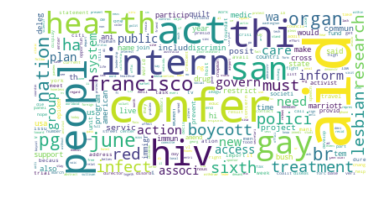

In [26]:
#Let's visualize this a bit.
%matplotlib inline
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(background_color = "white", max_words = 500)
wc.generate_from_frequencies(word_freq)

plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

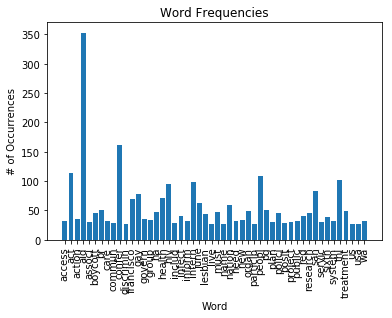

In [38]:
#Maybe this isn't giving as much info as we'd like...
#Let's do a barchart instead.
plt.title("Word Frequencies")
plt.ylabel("# of Occurrences")
plt.xlabel("Word")

plt.bar([i[0] for i in top_fifty], [i[1] for i in top_fifty])
plt.xticks(rotation='vertical')
plt.show()

In [39]:
#Okay, now we've got the basics!
#Let's move on to vectorization.
#We'll start with bag of words.

#Actually! We already did that. This is a big of words here:
print(top_fifty)

[('aid', 353), ('confer', 161), ('act', 114), ('peopl', 109), ('thi', 102), ('intern', 98), ('hiv', 95), ('san', 83), ('gay', 78), ('health', 71), ('francisco', 70), ('june', 63), ('nation', 59), ('br', 51), ('pg', 51), ('organ', 49), ('treatment', 49), ('ha', 47), ('must', 47), ('research', 46), ('polici', 46), ('boycott', 45), ('lesbian', 43), ('red', 41), ('infect', 40), ('sixth', 39), ('govern', 35), ('action', 35), ('new', 34), ('group', 34), ('need', 32), ('inform', 32), ('care', 31), ('public', 31), ('access', 31), ('system', 31), ('wa', 31), ('associ', 30), ('plan', 30), ('project', 30), ('servic', 30), ('posit', 29), ('includ', 29), ('commun', 28), ('particip', 27), ('discrimin', 27), ('name', 27), ('us', 27), ('live', 26), ('usa', 26)]


In [40]:
#However, what we really want is this part:
print([i[1] for i in top_fifty])

#This is our vector.

[353, 161, 114, 109, 102, 98, 95, 83, 78, 71, 70, 63, 59, 51, 51, 49, 49, 47, 47, 46, 46, 45, 43, 41, 40, 39, 35, 35, 34, 34, 32, 32, 31, 31, 31, 31, 31, 30, 30, 30, 30, 29, 29, 28, 27, 27, 27, 27, 26, 26]


In [41]:
#Whereas this, is our vocabulary;
print([i[0] for i in top_fifty])

#What information do we lose by vectorizing?
#How could we try to retain that knowledge?

['aid', 'confer', 'act', 'peopl', 'thi', 'intern', 'hiv', 'san', 'gay', 'health', 'francisco', 'june', 'nation', 'br', 'pg', 'organ', 'treatment', 'ha', 'must', 'research', 'polici', 'boycott', 'lesbian', 'red', 'infect', 'sixth', 'govern', 'action', 'new', 'group', 'need', 'inform', 'care', 'public', 'access', 'system', 'wa', 'associ', 'plan', 'project', 'servic', 'posit', 'includ', 'commun', 'particip', 'discrimin', 'name', 'us', 'live', 'usa']


In [42]:
#So do we have to do all of the above steps for every document?
#Thankfully, not really! sklearn and nltk do a lot of that for us.
#(Except the OCR correction... We still have to do that mostly ourselves.)
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

token = RegexpTokenizer(r'[a-zA-z0-9]+')
cv = CountVectorizer(lowercase=True, stop_words='english', ngram_range=(1,1), tokenizer=token.tokenize)


In [54]:
#Let's make sure we remember to use wordninja!

#Let's pick 50 documents from two collections to compare.
#Which two collections should we use?
#It could be interesting to compare a government/legal
#collection to a more personal collection.

unique_collect = set(list(df['call_no']))
collection_freq = {}
for collect in unique_collect:
    collection_freq[collect] = list(df['call_no']).count(collect)
    
print(collection_freq)

#Let's use:
#  2000-46 - AIDS Legal Referral Panel Records (85 records)
#  2003-09 - Linda Alband Collection of Randy Shilts Materials (209 records)

aids_legal_referral_papers = df['call_no'] == '2000-46'
linda_alband_papers = df['call_no'] == '2003-09'

aids_legal_referral_papers_50_random = df[aids_legal_referral_papers].sample(n = 50)
linda_alband_papers_50_random = df[linda_alband_papers].sample(n = 50)

{'MSS-98-47': 20, 'no-data': 9, 'SFH-71': 7, 'MSS-2001-04': 21, 'GLC-63': 6, 'MSS-2000-31': 49, '2005-13': 3, '2003-09': 209, 'MSS-95-04': 93, 'blank': 4, 'MSS-95-03': 144, 'SFH-31': 27, '2000-46': 85, 'MSS-98-48': 28, 'MSS-2009-04': 30}


In [64]:
#Now let's correct these.
corrected_ocr_aids_legal = []
for x in aids_legal_referral_papers_50_random["Ocr text"]:
    sentences = sent_tokenize(document_text)
    corrected_sentences = []
    for sentence in sentences:
        spell_checked_words = wordninja.split(sentence)
        corrected_sentence = " ".join(spell_checked_words)
        corrected_sentences.append(corrected_sentence)
    corrected_ocr_aids_legal.append(" ".join(corrected_sentences))
    
corrected_ocr_linda_alband = []
for x in linda_alband_papers_50_random["Ocr text"]:
    sentences = sent_tokenize(document_text)
    corrected_sentences = []
    for sentence in sentences:
        spell_checked_words = wordninja.split(sentence)
        corrected_sentence = " ".join(spell_checked_words)
        corrected_sentences.append(corrected_sentence)
    corrected_ocr_linda_alband.append(" ".join(corrected_sentences))
    
#Let's look at a couple.
print(corrected_ocr_linda_alband[:2])

["The Quilt An International AIDS Memorial CONTACT Dan Sauro Sue Baelen FOR IMMEDIATE RELEASE 415 863 5511 Phone 415 863 0708 Fax NAMES PROJECT JOINS BOYCOTT OF Vl th INTERNATIONAL CONFERENCE ON AIDS Action Supports Permanent Lifting of U S Travel Restrictions for HIV Infected Persons Sections of the AIDS Memorial Quilt Still to be Displayed in San Francisco in Con jim c tion With Lesbian and Gay Pride Weekend San Francisco CA March 15 1990 The Board of Directors of the NAMES Project Foundation the San Fr and sco based sponsor of the International AIDS Memorial Quilt have ded ded to boycott the Vl th International Conference on AIDS which will beheld in San Fr and sco June 20 24 The boycott is in response to the U 5 federal government's visa restrictions discriminating against people with HIV infection The temporary lifting of these restrictions is ii u u ff ici ent and does not alter boycott plans It is with mixed emotions that we announce our de dsi on to boycott said David Le mos Ac

In [65]:
#Next, we'll paste these to our small dataframes.
aids_legal_referral_papers_50_random["CorrectedOCR"] = corrected_ocr_aids_legal
linda_alband_papers_50_random["CorrectedOCR"] = corrected_ocr_linda_alband

#And then we'll add a column with "0" for dritz_selma and "1" for sue_rochman.
aids_legal_referral_papers_50_random["Class"] = [0] * 50
linda_alband_papers_50_random["Class"] = [1] * 50

#Let's look at a couple.
print(linda_alband_papers_50_random[:2])

(50, 54)
50
                                      Collection Title  \
268  Linda Alband collection of Randy Shilts materi...   
230  Linda Alband collection of Randy Shilts materi...   

                       Title       Local Identifier  Type       Date  \
268                 Journals  glbths_200309_002_018  text  1974-1986   
230  Articles and interviews  glbths_200309_001_033  text  1979-1994   

    Date Type                       Publication/Origination Info  \
268   created  Digital resource published by the Regents of t...   
230   created  Digital resource published by the Regents of t...   

    Creator 1 Name Creator 1 NameType Creator 1 Source  ...   \
268  Alband, Linda           persname              NaN  ...    
230  Alband, Linda           persname              NaN  ...    

    Subject (Topic) 5 Heading Subject (Topic) 5 Heading Type  \
268                                                            
230                                                            

    S

In [68]:
#Finally, we'll paste these two dataframes together.
complete_df = pd.concat([aids_legal_referral_papers_50_random, linda_alband_papers_50_random], axis=0)
print(complete_df[:2])

                                     Collection Title     Title  \
20  AIDS Legal Referral Panel Records, 2000-46, Bo...  Form 990   
66  AIDS Legal Referral Panel Records, 2000-46, Bo...   Minutes   

         Local Identifier  Type               Date Date Type  \
20  glbths_200046_007_004  text  November 15, 1986   created   
66  glbths_200046_002_001  text          1992-1993   created   

                         Publication/Origination Info  \
20  Digital resource published by the Regents of t...   
66  Digital resource published by the Regents of t...   

               Creator 1 Name Creator 1 NameType Creator 1 Source  ...   \
20  AIDS Legal Referral Panel           corpname              naf  ...    
66  AIDS Legal Referral Panel           corpname              naf  ...    

   Subject (Topic) 5 Heading Subject (Topic) 5 Heading Type  \
20                                                            
66                                                            

   Subject (Topic

In [69]:
#Now let's finish preprocessing by vectorizing!
text_counts = cv.fit_transform(complete_df['CorrectedOCR'])

print(text_counts[:2])

  (0, 145)	1
  (0, 157)	1
  (0, 154)	1
  (0, 86)	1
  (0, 863)	1
  (0, 1063)	1
  (0, 164)	1
  (0, 124)	1
  (0, 77)	3
  (0, 90)	1
  (0, 156)	1
  (0, 82)	2
  (0, 1349)	2
  (0, 2107)	2
  (0, 1575)	2
  (0, 1042)	2
  (0, 58)	2
  (0, 344)	2
  (0, 546)	1
  (0, 1062)	1
  (0, 905)	2
  (0, 2117)	3
  (0, 870)	2
  (0, 3258)	2
  (0, 2829)	2
  :	:
  (1, 211)	28
  (1, 759)	151
  (1, 3230)	24
  (1, 3452)	15
  (1, 520)	44
  (1, 1833)	7
  (1, 2591)	30
  (1, 2184)	22
  (1, 1290)	16
  (1, 10)	3
  (1, 2459)	7
  (1, 122)	3
  (1, 160)	9
  (1, 101)	20
  (1, 2730)	6
  (1, 1682)	8
  (1, 443)	1
  (1, 3131)	1
  (1, 2872)	1
  (1, 882)	1
  (1, 784)	13
  (1, 2090)	12
  (1, 285)	330
  (1, 1770)	94
  (1, 2647)	25


In [78]:
#Now let's split our data into a training and testing sets.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    text_counts,
    complete_df['Class'],
    test_size = 0.3,
    random_state = 100
)

In [79]:
#Next we'll use a multinomial Naive Bayes classifier to see how well we can predict which set a document is in.
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

clf = MultinomialNB().fit(X_train, y_train)
predicted = clf.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))

MultinomialNB Accuracy: 0.45


In [82]:
#Whoops... That's not so great (unless you got a great random split).
#Feel free to experiment with different test_size parameters!

#Here we'll try TF-IDF instead!
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

tf = TfidfVectorizer()
text_tf = tf.fit_transform(complete_df['CorrectedOCR'])

X_train, X_test, y_train, y_test = train_test_split(
    text_tf, 
    complete_df['Class'], 
    test_size = 0.3,
    random_state = 200
)

In [83]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

clf = MultinomialNB().fit(X_train, y_train)
predicted = clf.predict(X_test)
print("MultinomialNB Accuracy:", metrics.accuracy_score(y_test, predicted))

MultinomialNB Accuracy: 0.36666666666666664


In [90]:
#What if we change the classifier type?
#SGD Classifier?
#How many iterations should we use?
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(max_iter=20, tol=1e-3).fit(X_train, y_train)
predicted = clf.predict(X_test)
print("SGDClassifier Accuracy:", metrics.accuracy_score(y_test, predicted))

SGDClassifier Accuracy: 0.6333333333333333


In [91]:
#We could also try a couple more!
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron

#PassiveAggressiveClassifier
clf = PassiveAggressiveClassifier(tol=1e-3).fit(X_train, y_train)
predicted = clf.predict(X_test)
print("PassiveAggressiveClassifier Accuracy:", metrics.accuracy_score(y_test, predicted))

#Perceptron
clf = Perceptron(tol=1e-3).fit(X_train, y_train)
predicted = clf.predict(X_test)
print("Perceptron Accuracy:", metrics.accuracy_score(y_test, predicted))

PassiveAggressiveClassifier Accuracy: 0.36666666666666664
Perceptron Accuracy: 0.6333333333333333


In [ ]:
#Unfortunately, we probably don't have much time to continue
#this, but with more documents and corrected text, we
#could summarize whole collections, predict if a document
#belongs to a collection, or even generate completely new
#documents! See here:
#https://www.analyticsvidhya.com/blog/2018/03/text-generation-using-python-nlp/